# Carregando os arquivos de imagens a partir dos subdiretórios "ICDR" + "0", "1", "2", "3" ou "4" conforme a classificação dada no arquivo Einsteinlabels2.csv que contém os rótulos das imagens

Baseado em Image classification from scratch https://keras.io/examples/vision/image_classification_from_scratch/ 

In [9]:
%pip install tensorflow==2.7.0

ERROR: Could not install packages due to an OSError: [WinError 5] Acesso negado: 'C:\\Users\\Resource\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\~-nsorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.




  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [8]:
%pip list tensorflow

Package                 Version
----------------------- -------------------
absl-py                 0.15.0
argon2-cffi             20.1.0
astunparse              1.6.3
async-generator         1.10
attrs                   21.2.0
backcall                0.2.0
bleach                  3.3.1
cached-property         1.5.2
cachetools              4.2.4
certifi                 2021.10.8
cffi                    1.14.6
charset-normalizer      2.0.7
clang                   5.0
click                   8.0.3
colorama                0.4.4
cycler                  0.10.0
debugpy                 1.4.1
decorator               5.0.9
defusedxml              0.7.1
entrypoints             0.3
et-xmlfile              1.1.0
flatbuffers             1.12
gast                    0.4.0
Note: you may need to restart the kernel to use updated packages.geographiclib           1.52
geopy                   2.2.0
google-auth             2.3.0
google-auth-oauthlib    0.4.6
google-pasta            0.2.0
grpcio           

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
path_arq = r'C:\Users\Resource\Resource Tecnologia e Informatica Ltda\Data Science & Analytics - General\Projetos Internos'
path_arq += r'\Datathon\Einstein Frontiers\Images_mn_drctr'

In [3]:
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_arq,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path_arq,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred'
)


Found 1133 files belonging to 5 classes.
Using 907 files for training.
Found 1133 files belonging to 5 classes.
Using 226 files for validation.


In [4]:
len(val_ds)

8

In [5]:
len(train_ds)

29

# Visualizando os dados

Aqui estão as primeiras 9 imagens do conjunto de dados de treinamento. O marcador 0 é "ICDR0", o marcador 1 é "ICDR1" e assim por diante.

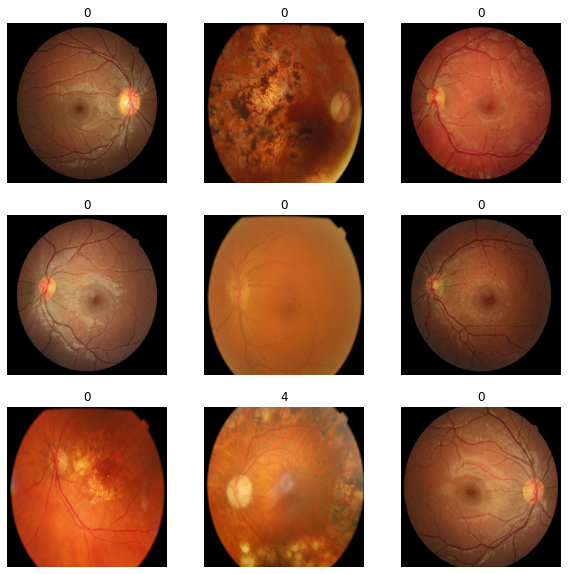

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


# Usando o aumento de dados de imagem

Quando você não tem um grande conjunto de dados de imagens, é uma boa prática introduzir artificialmente a diversidade da amostra aplicando transformações aleatórias, porém realistas, às imagens de treinamento, como inversão horizontal aleatória ou pequenas rotações aleatórias. Isso ajuda a expor o modelo a diferentes aspectos dos dados de treinamento, ao mesmo tempo que desacelera o overfitting.

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [8]:
data_augmentation

## Vamos visualizar a aparência das amostras aumentadas, aplicando data_augmentation repetidamente à primeira imagem no conjunto de dados:

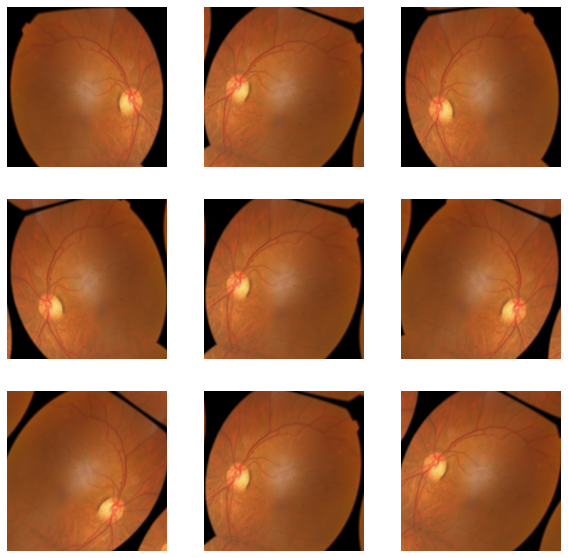

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Aplique-o ao conjunto de dados , de forma a obter um conjunto de dados que gere lotes de imagens aumentadas, como este:

In [10]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

Com esta opção, seu aumento de dados acontecerá na CPU , de forma assíncrona, e será armazenado em buffer antes de entrar no modelo.

Se você estiver treinando na CPU, esta é a melhor opção, pois torna o aumento de dados assíncrono e sem bloqueio.

# Padronizando os dados

Nossa imagem já está em um tamanho padrão (256 x 256), pois elas estão sendo produzidas como lotes de float32 contíguos por nosso conjunto de dados. No entanto, seus valores de canal RGB estão na faixa [0, 255]. Isso não é ideal para uma rede neural; em geral, você deve tentar diminuir os valores de entrada. Aqui, padronizaremos os valores para [0, 1] usando uma camada Rescaling no início do nosso modelo.

In [ ]:
# x = layers.Rescaling(1./255)(x)

# Configurando o conjunto de dados para desempenho

Vamos nos certificar de usar a pré-busca em buffer para que possamos gerar dados do disco sem que o I / O se torne o bloqueio:

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## How to deal with Unbalanced Image Datasets in less than 20 lines of code
ImageDataGenerator + RandomOverSampling
https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9

In [24]:
# %pip install imblearn

You should consider upgrading via the 'C:\Users\Resource\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [53]:
%pip install keras==2.4.*

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement keras==2.5.* (from versions: 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.0.6, 1.0.7, 1.0.8, 1.1.0, 1.1.1, 1.1.2, 1.2.0, 1.2.1, 1.2.2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.0.5, 2.0.6, 2.0.7, 2.0.8, 2.0.9, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.1.5, 2.1.6, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.2.4, 2.2.5, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.5.0rc0, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0rc3, 2.6.0, 2.7.0rc0, 2.7.0rc2, 2.7.0)
ERROR: No matching distribution found for keras==2.5.*


In [49]:
#from keras import utils as np_utils

In [50]:
from keras.utils.data_utils import Sequence

In [51]:
from imblearn.over_sampling import RandomOverSampler

In [52]:
from imblearn.keras import balanced_batch_generator

AttributeError: module 'keras.utils' has no attribute 'Sequence'

In [25]:



class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

AttributeError: module 'keras.utils' has no attribute 'Sequence'

# Modelo do artigo

Vamos construir uma pequena versão da rede Xception. Não tentamos particularmente otimizar a arquitetura; se você quiser fazer uma busca sistemática pela melhor configuração de modelo, considere o uso do KerasTuner .

Observe que:

    Iniciamos o modelo com o pré-processador data_augmentation, seguido por uma camada Rescaling.
    Incluímos uma camada Dropout antes da camada de classificação final.


In [13]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
keras.utils.plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


## Treinando o modelo

In [17]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


ValueError: in user code:

    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\Resource\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\ops\nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 5) vs (None, 1))


In [ ]:
# Our vectorized labels
# y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
# y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

Obtemos uma precisão de validação de aproximadamente 96% após o treinamento de 50 épocas no conjunto de dados completo.

# Modelo da página [Classificação de Imagem](https://www.tensorflow.org/tutorials/images/classification)

## Configure o conjunto de dados para desempenho

Vamos nos certificar de usar a pré-busca em buffer para que você possa gerar dados do disco sem que o I / O se torne um bloqueio. Estes são dois métodos importantes que você deve usar ao carregar dados:

    Dataset.cache mantém as imagens na memória depois de serem carregadas fora do disco durante a primeira época. Isso garantirá que o conjunto de dados não se torne um gargalo durante o treinamento do seu modelo. Se o seu conjunto de dados for muito grande para caber na memória, você também pode usar este método para criar um cache em disco de alto desempenho.
    Dataset.prefetch sobrepõe dados de pré-processamento e execução do modelo durante o treinamento.

Os leitores interessados podem saber mais sobre ambos os métodos, bem como a forma de dados em cache no disco na seção Prefetching do desempenho melhor com a tf.data API guia.

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Criando o modelo

O modelo sequencial consiste em três blocos de convolução ( tf.keras.layers.Conv2D ) com uma camada de pooling max ( tf.keras.layers.MaxPooling2D ) em cada um deles. Há uma camada completamente ligada ( tf.keras.layers.Dense ) com 128 unidades em cima do que é activada por uma função de activação Relu ( 'relu' ). Este modelo não foi ajustado para alta precisão - o objetivo deste tutorial é mostrar uma abordagem padrão.

In [6]:
img_height = 256
img_width = 256

In [26]:
num_classes = 5

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile o modelo

Para este tutorial, escolha o tf.keras.optimizers.Adam otimizador e tf.keras.losses.SparseCategoricalCrossentropy função de perda. Para treinamento vista e precisão de validação para cada época de treinamento, passar a metrics argumento para Model.compile.

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Resumo do modelo

Ver todas as camadas da rede usando o modelo Model.summary método:

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)       

## Treine o modelo

In [29]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs = epochs
)

Epoch 1/10
29/29 [==============================] - 153s 3s/step - loss: 1.0291 - accuracy: 0.7244 - val_loss: 0.8441 - val_accuracy: 0.7743
Epoch 2/10
29/29 [==============================] - 69s 2s/step - loss: 0.8887 - accuracy: 0.7508 - val_loss: 0.8366 - val_accuracy: 0.7743
Epoch 3/10
29/29 [==============================] - 44s 2s/step - loss: 0.8887 - accuracy: 0.7508 - val_loss: 0.8758 - val_accuracy: 0.7743
Epoch 4/10
29/29 [==============================] - 44s 2s/step - loss: 0.8774 - accuracy: 0.7508 - val_loss: 0.8614 - val_accuracy: 0.7743
Epoch 5/10
29/29 [==============================] - 42s 1s/step - loss: 0.8346 - accuracy: 0.7475 - val_loss: 0.8634 - val_accuracy: 0.7743
Epoch 6/10
29/29 [==============================] - 43s 1s/step - loss: 0.8669 - accuracy: 0.7552 - val_loss: 0.9106 - val_accuracy: 0.7743
Epoch 7/10
29/29 [==============================] - 44s 2s/step - loss: 0.8009 - accuracy: 0.7552 - val_loss: 0.9631 - val_accuracy: 0.7743
Epoch 8/10
29/29 [=

## Visualize os resultados do treinamento
Crie gráficos de perda e precisão nos conjuntos de treinamento e validação:

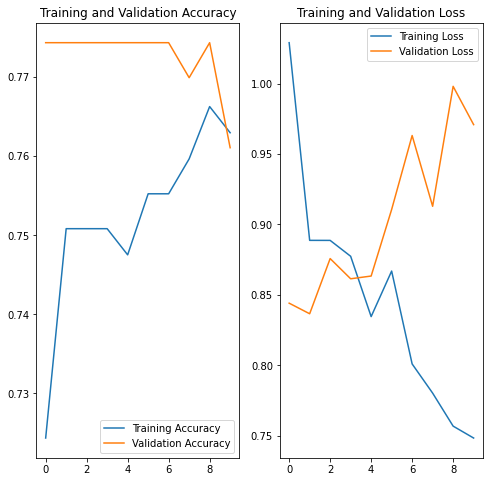

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


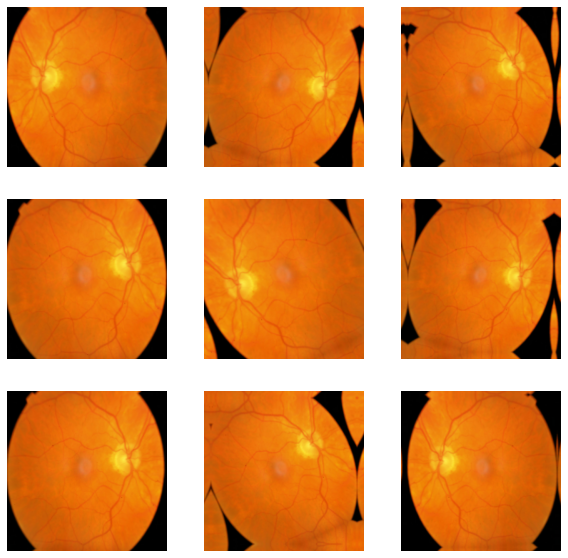

In [32]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [33]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [35]:
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)       

In [36]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
29/29 [==============================] - 80s 3s/step - loss: 1.0904 - accuracy: 0.7376 - val_loss: 0.8476 - val_accuracy: 0.7743
Epoch 2/15
29/29 [==============================] - 61s 2s/step - loss: 0.9015 - accuracy: 0.7508 - val_loss: 0.8128 - val_accuracy: 0.7743
Epoch 3/15
29/29 [==============================] - 56s 2s/step - loss: 0.9032 - accuracy: 0.7508 - val_loss: 0.8426 - val_accuracy: 0.7743
Epoch 4/15
29/29 [==============================] - 53s 2s/step - loss: 0.8913 - accuracy: 0.7508 - val_loss: 0.8603 - val_accuracy: 0.7743
Epoch 5/15
29/29 [==============================] - 61s 2s/step - loss: 0.9002 - accuracy: 0.7508 - val_loss: 0.8243 - val_accuracy: 0.7743
Epoch 6/15
29/29 [==============================] - 56s 2s/step - loss: 0.8843 - accuracy: 0.7508 - val_loss: 0.8307 - val_accuracy: 0.7743
Epoch 7/15
29/29 [==============================] - 68s 2s/step - loss: 0.8765 - accuracy: 0.7508 - val_loss: 0.8424 - val_accuracy: 0.7743
Epoch 8/15
29/29 [==

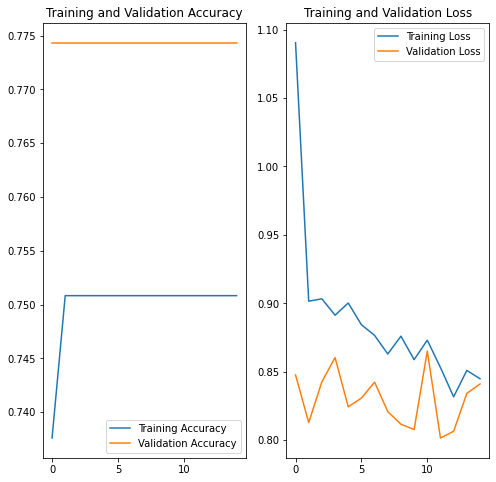

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Montando um modelo mais lógico

## Configurando o conjunto de dados para desempenho
Vamos nos certificar de usar a pré-busca em buffer para que você possa gerar dados do disco sem que o I / O se torne um bloqueio. Estes são dois métodos importantes que você deve usar ao carregar dados:

    Dataset.cache mantém as imagens na memória depois de serem carregadas fora do disco durante a primeira época. Isso garantirá que o conjunto de dados não se torne um gargalo durante o treinamento do seu modelo. Se o seu conjunto de dados for muito grande para caber na memória, você também pode usar este método para criar um cache em disco de alto desempenho.
    Dataset.prefetch sobrepõe dados de pré-processamento e execução do modelo durante o treinamento.

Os leitores interessados podem saber mais sobre ambos os métodos, bem como a forma de dados em cache no disco na seção Prefetching do desempenho melhor com a tf.data API guia.

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Data augmentation

In [9]:
img_height = 256
img_width = 256

In [10]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


In [11]:
num_classes = 5

In [12]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

## Compile o modelo
Para este modelo, escolhemos o otimizador tf.keras.optimizers.Adam e a função de perda tf.keras.losses.SparseCategoricalCrossentropy. Para treinamento vista e precisão de validação para cada época de treinamento, passar a metrics argumento para Model.compile.

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
